<a href="https://colab.research.google.com/github/arun-arunisto/PyTorch-Tutorial/blob/main/Tutorial_3_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use `transforms` to perform some manipulation of the data and make it suitable for training.

## Getting started with transforms v2

For this we will cover simple tasks like image classification, and more advanced ones like object detection / segmentation.


In [1]:
#importing libraries
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
from torchvision.transforms import v2
from torchvision.io import decode_image

torch.manual_seed(1)

`torch.manual_seed(1)` - By setting the seed to a fixed value, you ensure that the random numbers generated by PyTorch will be the same every time you run your code. This is crucial for reproducible experiments in machine learning. If you don't set a seed, the random numbers will vary each time you run the code, potentially leading to different results.

In [3]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [4]:
img = decode_image(str(Path('/content/drive/MyDrive/data/astronaut.jpg')))

In [5]:
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 512, 512])


## Basics

The Torchvision transforms behave like a regular `torch.nn.Module` (in fact, most of them are): instantiate a transform, pass an input, get a transformed output:

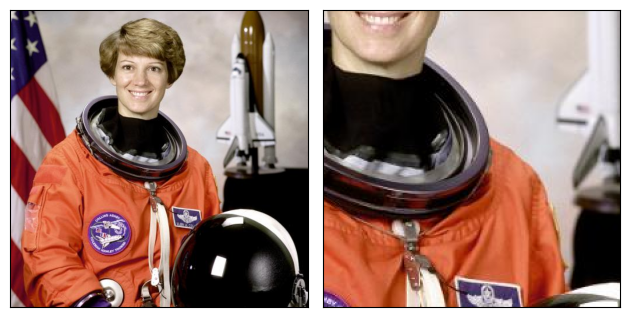

In [6]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

## Image Classification

For image classification it's very simple. A basic classification pipeline may look like this:

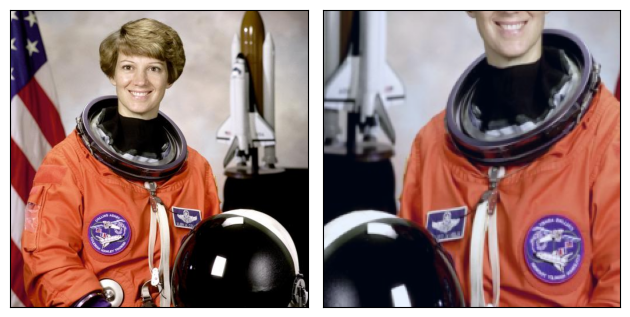

In [7]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

Such transformation pipeline is typically passed as the transform argument to the Datasets, e.g. ImageNet(..., transform=transforms).

## Detection, Segmentation or Videos

The new Torchvision transforms in the `torchvision.transforms.v2` namespace support tasks beyond image classification: they can also transform bounding boxes, segmentation / detection masks, or videos.

<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


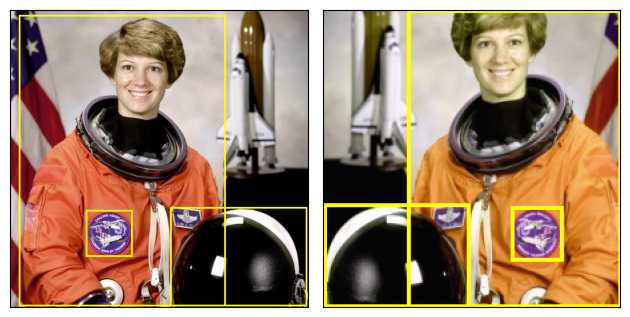

In [8]:
#detection example with bounding boxes
boxes = tv_tensors.BoundingBoxes(
    [
        [15, 10, 370, 510],
        [275, 340, 510, 510],
        [130, 345, 210, 425]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])

## TVTensors

TVTensors are `torch.Tensor` subclasses. The available TVTensors are Image, BoundingBoxes, Mask, and Video.

TVTensors look and feel just like regular tensors - they are tensors. Everything that is supported on a plain `torch.Tensor` like `.sum()` or any `torch.*` operator will also work on a TVTensor:

In [9]:
img_dp = tv_tensors.Image(torch.randint(0, 256, (3, 256, 256), dtype=torch.uint8))

print(f"{isinstance(img_dp, torch.Tensor) = }")
print(f"{img_dp.dtype = }, {img_dp.shape = }, {img_dp.sum() = }")

isinstance(img_dp, torch.Tensor) = True
img_dp.dtype = torch.uint8, img_dp.shape = torch.Size([3, 256, 256]), img_dp.sum() = tensor(25087958)


These TVTensor classes are at the core of the transforms: in order to transform a given input, the transforms first look at the class of the object, and dispatch to the appropriate implementation accordingly.

## Passing Input

Above, we’ve seen two examples: one where we passed a single image as input i.e. `out = transforms(img)`, and one where we passed both an image and bounding boxes, i.e. `out_img, out_boxes = transforms(img, boxes)`.

In fact, transforms support arbitrary input structures. The input can be a single image, a tuple, an arbitrarily nested dictionary… pretty much anything. The same structure will be returned as output. Below, we use the same detection transforms, but pass a tuple (image, target_dict) as input and we’re getting the same structure as output:

('arbitrary', {'structure': '!'})


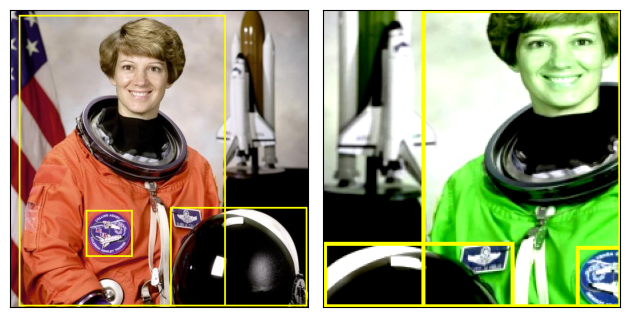

In [10]:
target = {
    "boxes": boxes,
    "labels": torch.arange(boxes.shape[0]),
    "this_is_ignored": ("arbitrary", {"structure": "!"})
}

# Re-using the transforms and definitions from above.
out_img, out_target = transforms(img, target)

plot([(img, target["boxes"]), (out_img, out_target["boxes"])])
print(f"{out_target['this_is_ignored']}")

We passed a tuple so we get a tuple back, and the second element is the tranformed target dict. Transforms don’t really care about the structure of the input; as mentioned above, they only care about the type of the objects and transforms them accordingly.

Foreign objects like strings or ints are simply passed-through. This can be useful e.g. if you want to associate a path with every single sample when debugging!

## Illustration of transforms

### Geometric Transforms

Geometric image transformation refers to the process of altering the geometric properties of an image, such as its shape, size, orientation, or position. It involves applying mathematical operations to the image pixels or coordinates to achieve the desired transformation.

#### Pad
The `Pad` transform (see also `pad()`) pads all image borders with some pixel values.

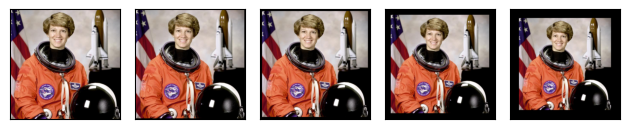

In [11]:
padded_imgs = [v2.Pad(padding=padding)(img) for padding in (3, 10, 30, 50)]
plot([img] + padded_imgs)

#### Resize
The `Resize` transform (see also `resize()`) resizes an image.

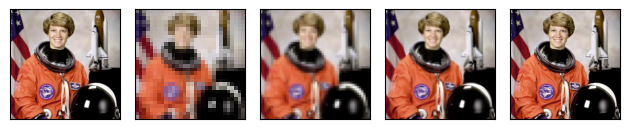

In [12]:
resized_imgs = [v2.Resize(size=size)(img) for size in (30, 50, 100, img.shape[-2:])]
plot([img] + resized_imgs)

#### CenterCrop

The `CenterCrop` transform (see also `center_crop()`) crops the given image at the center.

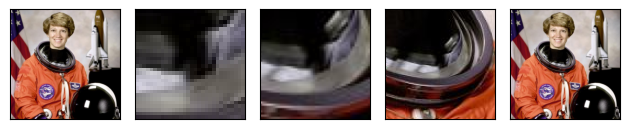

In [13]:
center_crops = [v2.CenterCrop(size=size)(img) for size in (30, 50, 100, img.shape[-2:])]
plot([img] + center_crops)

#### FiveCrop
The `FiveCrop` transform (see also `five_crop()`) crops the given image into four corners and the central crop.

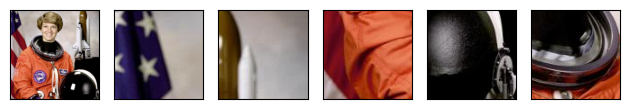

In [14]:
(top_left, top_right, bottom_left, bottom_right, center) = v2.FiveCrop(size=(100, 100))(img)
plot([img] + [top_left, top_right, bottom_left, bottom_right, center])

#### RandomPerspective

The `RandomPerspective` transform (see also `perspective()`) performs random perspective transform on an image.

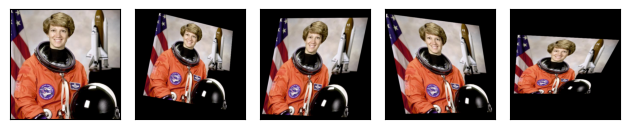

In [15]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(img) for _ in range(4)]
plot([img] + perspective_imgs)

#### RandomRotation

The `RandomRotation` transform (see also `rotate()`) rotates an image with random angle.

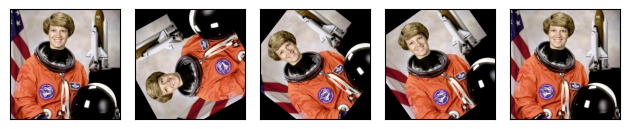

In [16]:
rotater = v2.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(img) for _ in range(4)]
plot([img] + rotated_imgs)

#### RandomAffine
The `RandomAffine` transform (see also `affine()`) performs random affine transform on an image.

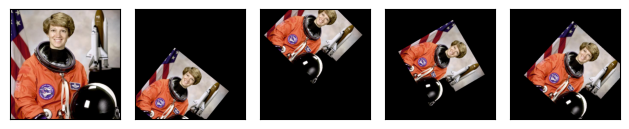

In [17]:
affine_transfomer = v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(img) for _ in range(4)]
plot([img] + affine_imgs)

#### Elastic Transform

The `ElasticTransform transform` (see also `elastic_transform()`) Randomly transforms the morphology of objects in images and produces a see-through-water-like effect.

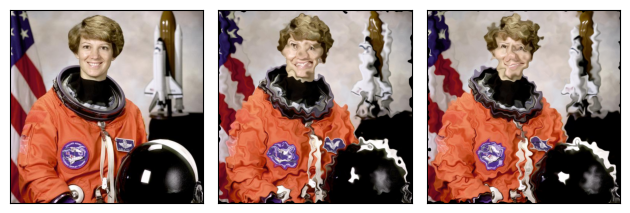

In [18]:
elastic_transformer = v2.ElasticTransform(alpha=250.0)
transformed_imgs = [elastic_transformer(img) for _ in range(2)]
plot([img] + transformed_imgs)

#### RandomCrop

The `RandomCrop` transform (see also `crop()`) crops an image at a random location.

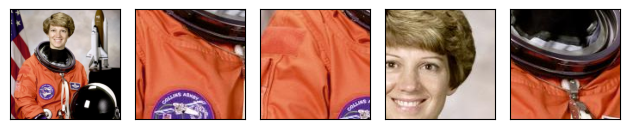

In [19]:
cropper = v2.RandomCrop(size=(128, 128))
crops = [cropper(img) for _ in range(4)]
plot([img] + crops)

#### RandomResizedCrop

The `RandomResizedCrop` transform (see also `resized_crop()`) crops an image at a random location, and then resizes the crop to a given size.

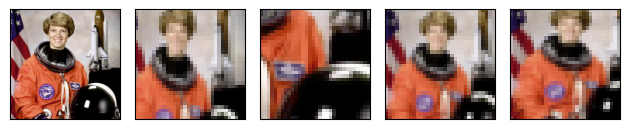

In [20]:
resize_cropper = v2.RandomResizedCrop(size=(32, 32))
resized_crops = [resize_cropper(img) for _ in range(4)]
plot([img] + resized_crops)

### Photometric Transforms

Photometric image transformation refers to the process of modifying the photometric properties of an image, such as its brightness, contrast, color, or tone. These transformations are applied to change the visual appearance of an image while preserving its geometric structure.

Except Grayscale, the following transforms are random, which means that the same transform instance will produce different result each time it transforms a given image.

#### Grayscale

The `Grayscale` transform (see also `to_grayscale()`) converts an image to grayscale

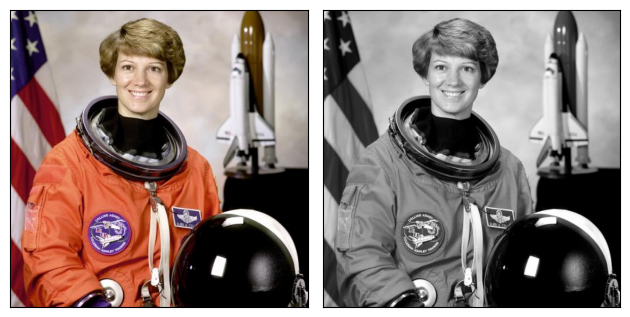

In [21]:
gray_img = v2.Grayscale()(img)
plot([img, gray_img], cmap='gray')

#### ColorJitter

The `ColorJitter` transform randomly changes the brightness, contrast, saturation, hue, and other properties of an image.

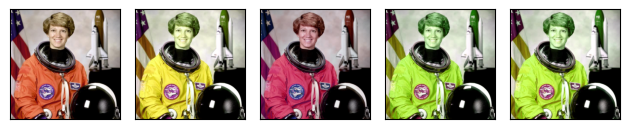

In [22]:
jitter = v2.ColorJitter(brightness=.5, hue=.3)
jittered_imgs = [jitter(img) for _ in range(4)]
plot([img] + jittered_imgs)

#### GaussianBlur

The `GaussianBlur` transform (see also `gaussian_blur()`) performs gaussian blur transform on an image.

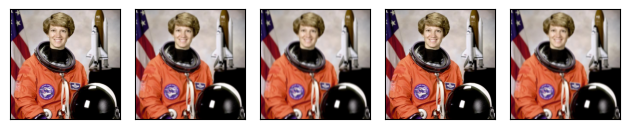

In [23]:
blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
blurred_imgs = [blurrer(img) for _ in range(4)]
plot([img] + blurred_imgs)

#### RandomInvert

The `RandomInvert` transform (see also `invert()`) randomly inverts the colors of the given image.

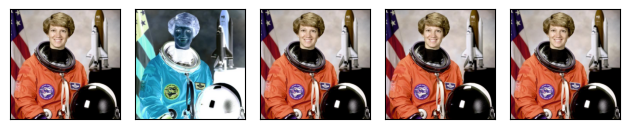

In [24]:
inverter = v2.RandomInvert()
invertered_imgs = [inverter(img) for _ in range(4)]
plot([img] + invertered_imgs)

#### RandomPosterize

The `RandomPosterize` transform (see also `posterize()`) randomly posterizes the image by reducing the number of bits of each color channel.

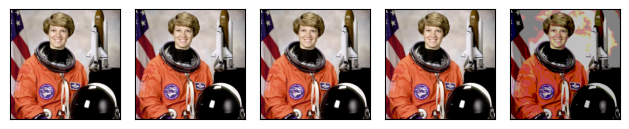

In [25]:
posterizer = v2.RandomPosterize(bits=2)
posterized_imgs = [posterizer(img) for _ in range(4)]
plot([img] + posterized_imgs)

#### RandomSolarize

The `RandomSolarize` transform (see also `solarize()`) randomly solarizes the image by inverting all pixel values above the threshold.

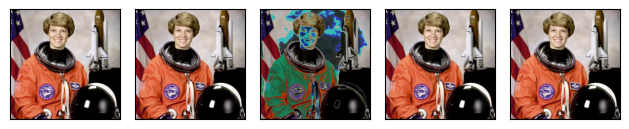

In [26]:
solarizer = v2.RandomSolarize(threshold=192.0)
solarized_imgs = [solarizer(img) for _ in range(4)]
plot([img] + solarized_imgs)

#### RandomAdjustSharpness

The `RandomAdjustSharpness` transform (see also `adjust_sharpness()`) randomly adjusts the sharpness of the given image.

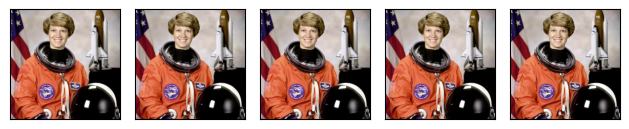

In [27]:
sharpness_adjuster = v2.RandomAdjustSharpness(sharpness_factor=2)
sharpened_imgs = [sharpness_adjuster(img) for _ in range(4)]
plot([img] + sharpened_imgs)

#### RandomAutoContrast

The `RandomAutocontrast` transform (see also `autocontrast()`) randomly applies autocontrast to the given image.

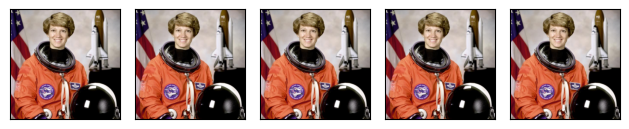

In [28]:
autocontraster = v2.RandomAutocontrast()
autocontrasted_imgs = [autocontraster(img) for _ in range(4)]
plot([img] + autocontrasted_imgs)

#### RandomEqualize

The `RandomEqualize` transform (see also `equalize()`) randomly equalizes the histogram of the given image.

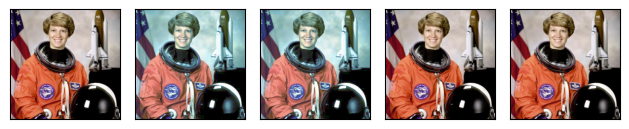

In [29]:
equalizer = v2.RandomEqualize()
equalized_imgs = [equalizer(img) for _ in range(4)]
plot([img] + equalized_imgs)

#### JPEG

The `JPEG` transform (see also `jpeg()`) applies JPEG compression to the given image with random degree of compression.

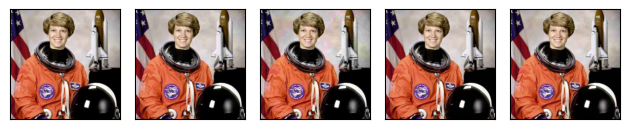

In [30]:
jpeg = v2.JPEG((5, 50))
jpeg_imgs = [jpeg(img) for _ in range(4)]
plot([img] + jpeg_imgs)

### Augmentation Tranforms

The following transforms are combinations of multiple transforms, either geometric or photometric, or both.

#### AutoAugment
The `AutoAugment` transform automatically augments data based on a given auto-augmentation policy.

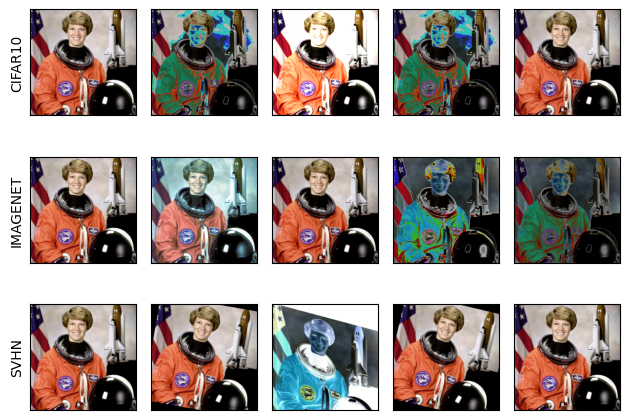

In [31]:
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot([[img] + row for row in imgs], row_title=row_title)

#### RandAugment

The RandAugment is an alternate version of AutoAugment.

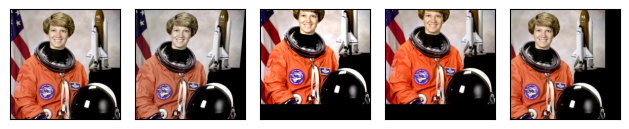

In [32]:
augmenter = v2.RandAugment()
imgs = [augmenter(img) for _ in range(4)]
plot([img] + imgs)

#### TrivialAugmentWide

The `TrivialAugmentWide` is an alternate implementation of AutoAugment. However, instead of transforming an image multiple times, it transforms an image only once using a random transform from a given list with a random strength number.

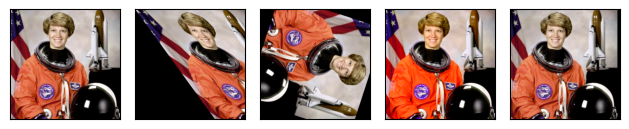

In [33]:
augmenter = v2.TrivialAugmentWide()
imgs = [augmenter(img) for _ in range(4)]
plot([img] + imgs)

#### AugMix

The `AugMix` transform interpolates between augmented versions of an image.

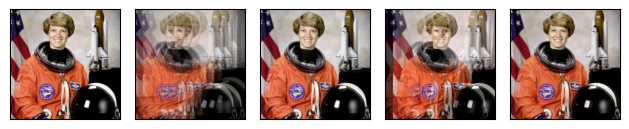

In [34]:
augmenter = v2.AugMix()
imgs = [augmenter(img) for _ in range(4)]
plot([img] + imgs)

### Randomly Applied Tranforms

The following transforms are randomly-applied given a probability `p`. That is, given `p = 0.5`, there is a 50% chance to return the original image, and a 50% chance to return the transformed image, even when called with the same transform instance!

#### RandomHorizontalFlip

The `RandomHorizontalFlip` transform (see also `hflip()`) performs horizontal flip of an image, with a given probability.

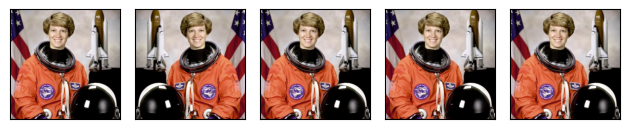

In [35]:
hflipper = v2.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(img) for _ in range(4)]
plot([img] + transformed_imgs)

#### RandomVerticalFlip

The `RandomVerticalFlip` transform (see also `vflip()`) performs vertical flip of an image, with a given probability.

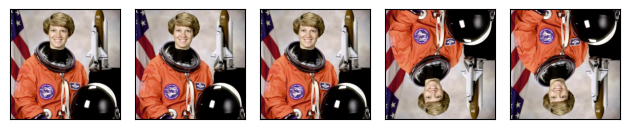

In [36]:
vflipper = v2.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(img) for _ in range(4)]
plot([img] + transformed_imgs)

#### RandomApply

The `RandomApply` transform randomly applies a list of transforms, with a given probability.

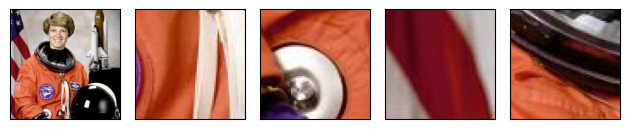

In [37]:
applier = v2.RandomApply(transforms=[v2.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(img) for _ in range(4)]
plot([img] + transformed_imgs)